<a href="https://colab.research.google.com/github/shawnchencun/cli-table/blob/master/Copy_of_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification

  - Cats and Dogs dataset

**VGG Architecture:**

VGG stands for Visual Geometry Group; it is a standard deep Convolutional Neural Network (CNN) architecture with multiple layers




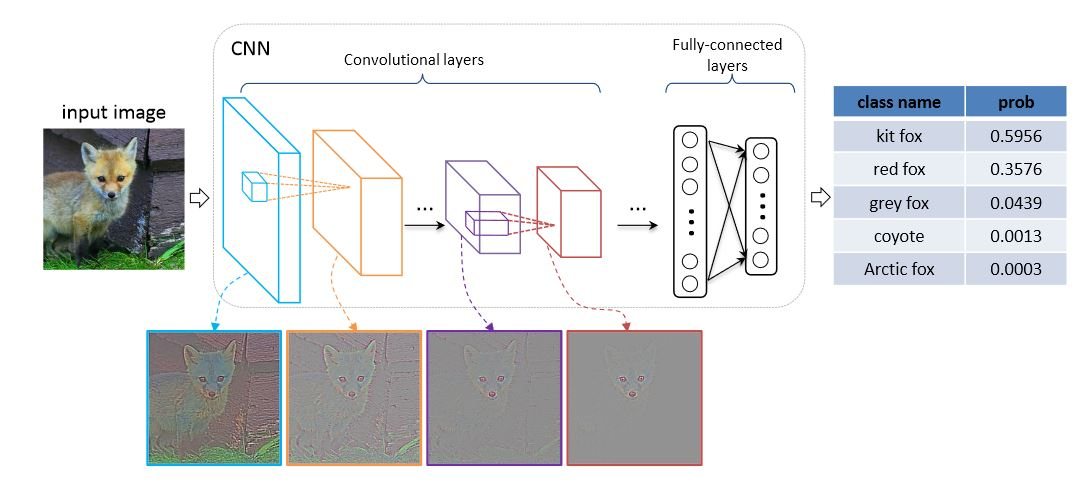


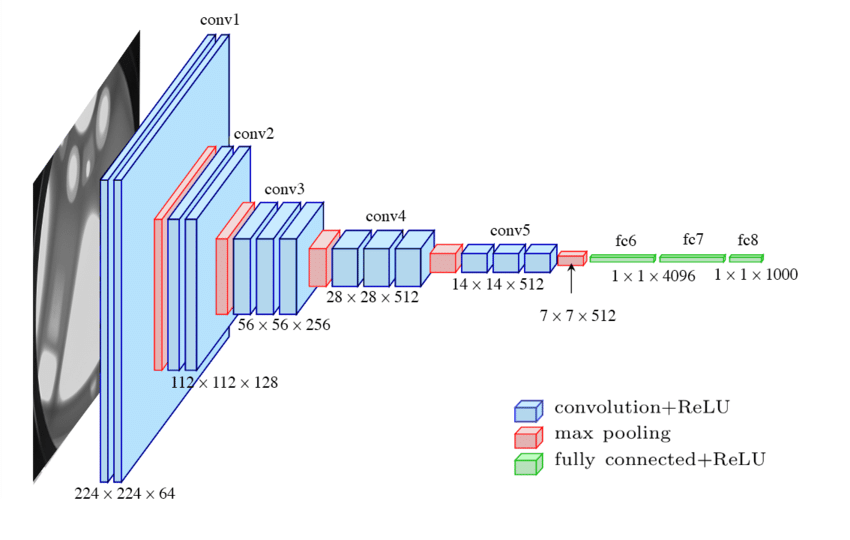

## Setup

In [ ]:
import tensorflow as tf
import keras
from keras import layers
from keras import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# Surpress the warnings
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # '3' silences everything

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

## Data preprocessing
### Data download
In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility.

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
img_height = 160
img_width = 160
IMG_SIZE = (img_height, img_width)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


### Show some images

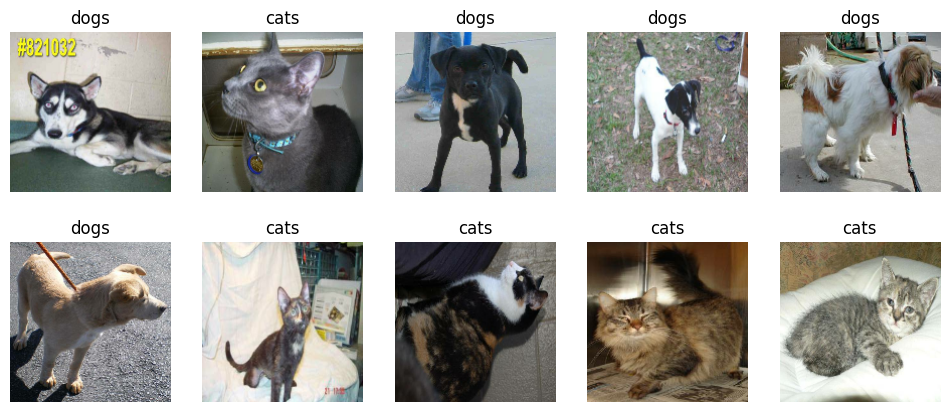

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(12, 5))
for images, labels in train_dataset.take(1):
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Split the data
As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance
Use buffered prefetching to load images from disk without having I/O become blocking.

To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## A basic Keras model
### VGG-1 model


In [ ]:
# define a model with 1 VGG block
model = Sequential([
  layers.Rescaling (1./255, input_shape=(160, 160, 3)),
  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
  layers.Dense(1, activation='sigmoid')
])

# compile the model
opt = keras.optimizers.SGD(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 160, 160, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 80, 80, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 204800)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      26,214,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,215,553 (100.00 MB)

 Trainable params: 26,215,553 (100.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# train the model
epochs=20
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - accuracy: 0.5030 - loss: 0.7386 - val_accuracy: 0.5990 - val_loss: 0.6708
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.5717 - loss: 0.6781 - val_accuracy: 0.5681 - val_loss: 0.6839
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.6037 - loss: 0.6656 - val_accuracy: 0.5569 - val_loss: 0.6800
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5955 - loss: 0.6598 - val_accuracy: 0.5743 - val_loss: 0.6738
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.6152 - loss: 0.6459 - val_accuracy: 0.5606 - val_loss: 0.6960
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6234 - loss: 0.6390 - val_accuracy: 0.6015 - val_loss: 0.6574
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6167 - loss: 0.6427 - val_accuracy: 0.6064 - val_loss: 0.6521
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.6337 - loss: 0.6314 - val_accuracy: 0.5693 - 

In [ ]:
# function to plot training history
def show_learning_curves(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs_range = range(epochs)
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.subplot(2, 1, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.show()


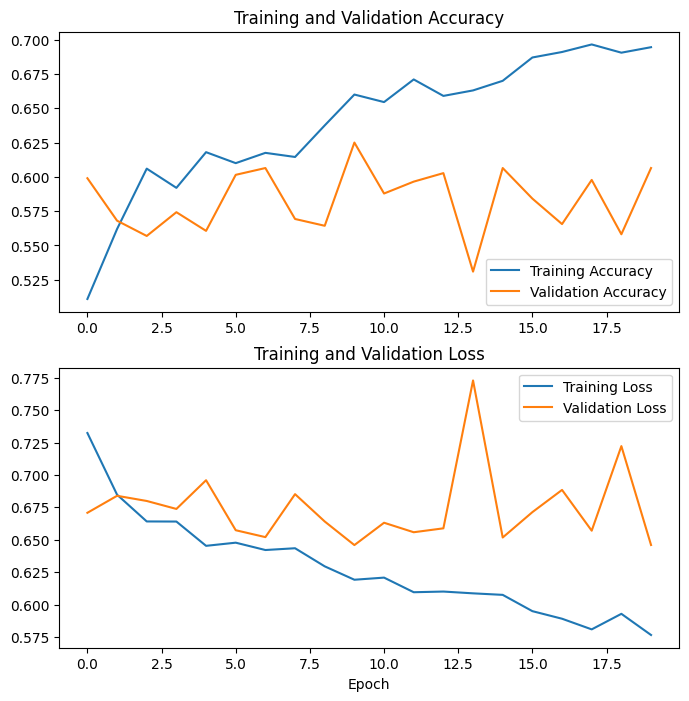

In [ ]:
# visualize training history
show_learning_curves(history)


### VGG-2 model

In [ ]:
# define a model with 2 VGG blocks
model = Sequential([
  layers.Rescaling (1./255, input_shape=(160, 160, 3)),

  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),

  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),

  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
  layers.Dense(1, activation='sigmoid')
])

# compile the model
opt = keras.optimizers.SGD(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# train the model
epochs=20
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.5268 - loss: 0.7021 - val_accuracy: 0.5198 - val_loss: 0.6957
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.5351 - loss: 0.6913 - val_accuracy: 0.5470 - val_loss: 0.6899
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.5572 - loss: 0.6803 - val_accuracy: 0.5322 - val_loss: 0.6891
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.5586 - loss: 0.6792 - val_accuracy: 0.5718 - val_loss: 0.6752
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.5795 - loss: 0.6759 - val_accuracy: 0.5384 - val_loss: 0.6914
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.5710 - loss: 0.6715 - val_accuracy: 0.5408 - val_loss: 0.6831
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.6013 - loss: 0.6630 - val_accuracy: 0.5594 - val_loss: 0.6738
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.5823 - loss: 0.6618 - val_accuracy: 0.5767 - v

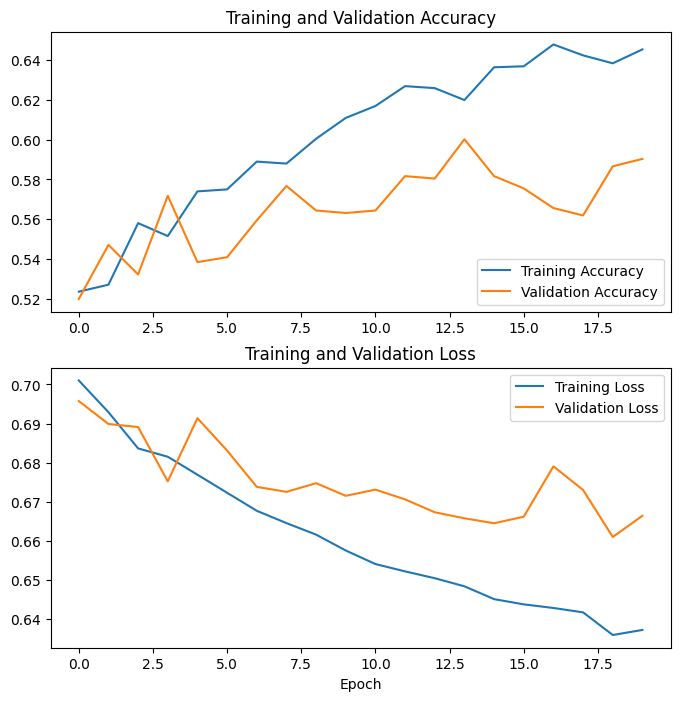

In [ ]:
# visualize training history
show_learning_curves(history)

### VGG-3 model

In [ ]:
# define a model with 3 VGG block3
model = Sequential([
  layers.Rescaling (1./255, input_shape=(160, 160, 3)),

  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),

  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),

  layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform'),
  layers.MaxPooling2D((2, 2)),

  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
  layers.Dense(1, activation='sigmoid')
])

# compile the model
opt = keras.optimizers.SGD(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# train the model
epochs=20
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.5282 - loss: 0.8251 - val_accuracy: 0.5408 - val_loss: 0.7027
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.5335 - loss: 0.6927 - val_accuracy: 0.5161 - val_loss: 0.6988
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.5424 - loss: 0.6856 - val_accuracy: 0.5260 - val_loss: 0.6942
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.5570 - loss: 0.6814 - val_accuracy: 0.5272 - val_loss: 0.6954
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.5643 - loss: 0.6795 - val_accuracy: 0.5495 - val_loss: 0.6866
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.5642 - loss: 0.6760 - val_accuracy: 0.5371 - val_loss: 0.6936
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.5798 - loss: 0.6713 - val_accuracy: 0.5483 - val_loss: 0.6827
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5906 - loss: 0.6693 - val_accuracy: 0.5631 - v

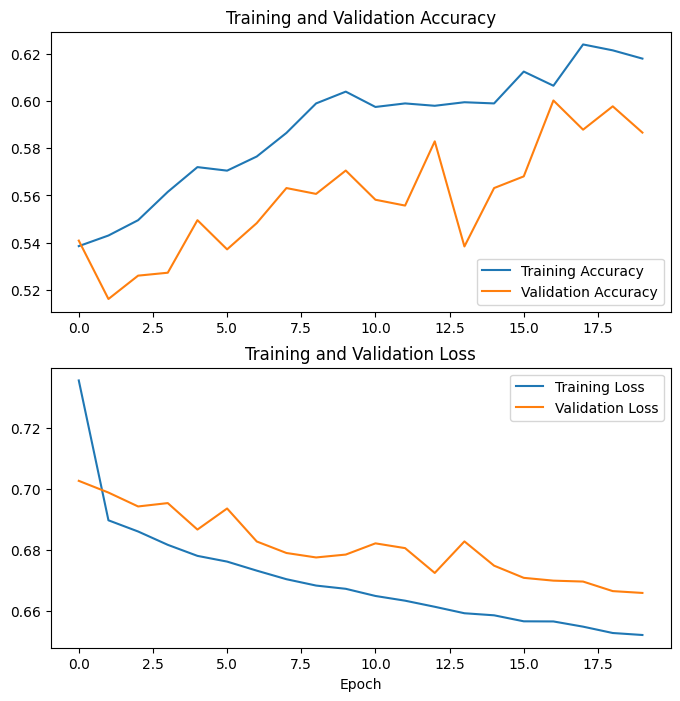

In [ ]:
# visualize training history
show_learning_curves(history)

### Data augmentation

In [ ]:
# data augmentation
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

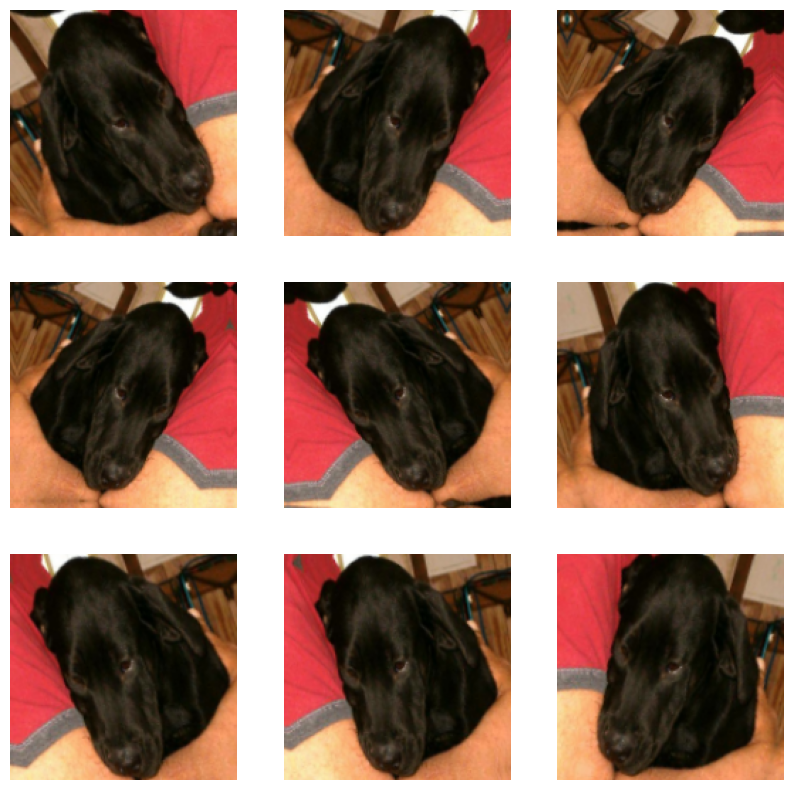

In [ ]:
# show some images
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Summary


As is shown above, the small dataset of 2000 images created challenges in achieving high generalization. Starting with a single VGG block, the model displayed limited accuracy as it was able to capture only basic patterns, leading to a relatively low validation accuracy around 60%. With such a small dataset, the model struggled to learn a wide range of features from scratch, which limited its effectiveness for the classification task.

Adding more layers improved the model’s ability to recognize more intricate patterns, as shown by increased training accuracy in the two-block and three-block VGG models. However, these models did not show substantial gains in validation accuracy, indicating that they were learning details specific to the training data. This discrepancy pointed to a limited generalization capability, with the training accuracy often significantly surpassing validation accuracy, especially in the deeper models.

The gap between training and validation accuracy suggested overfitting, a common issue in models trained on small datasets. While the added layers allowed the models to capture complex details, they led to overfitting rather than meaningful improvements in validation performance. This outcome highlights the limitations of training a CNN on a small dataset without pre-trained weights, as the model lacks exposure to the variety of features needed to generalize effectively to new images.

## Transfer Learning with MobileNet V2
You will create the base model from the MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### Rescale pixel values
MobileNetV2 model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

**Note:** Alternatively, you could rescale pixel values from [0, 255] to [-1, 1] using tf.keras.layers.Rescaling.

  rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

**Note:** If using other tf.keras.applications, be sure to check the API doc to determine if they expect pixels in [-1, 1] or [0, 1], or use the included preprocess_input function.

### Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base
It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [ ]:
# This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
# freeze the CNN base
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
# base_model.summary()

### Add a classification head
To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


**Apply a tf.keras.layers.Dense layer** to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


**Build a model** by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [ ]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Compile the model
Compile the model before training it. Since there are two classes, use the tf.keras.losses.BinaryCrossentropy loss with from_logits=True since the model provides a linear output.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

### Train the model
After training for 10 epochs, you should see ~96% accuracy on the validation set.

In [ ]:
# model performance before training

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.5438 - loss: 0.7320


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.75
initial accuracy: 0.53


In [ ]:
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.5578 - loss: 0.7712 - val_accuracy: 0.7265 - val_loss: 0.4610
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7468 - loss: 0.4866 - val_accuracy: 0.8094 - val_loss: 0.3392
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8139 - loss: 0.3631 - val_accuracy: 0.8651 - val_loss: 0.2628
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.8602 - loss: 0.3143 - val_accuracy: 0.8874 - val_loss: 0.2229
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8840 - loss: 0.2748 - val_accuracy: 0.9109 - val_loss: 0.1980
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8906 - loss: 0.2415 - val_accuracy: 0.9158 - val_loss: 0.1809
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.9121 - loss: 0.2194 - val_accuracy: 0.9245 - val_loss: 0.1651
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.9182 - loss: 0.2043 - val_accuracy: 0.9295 - v

### Learning curves
Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

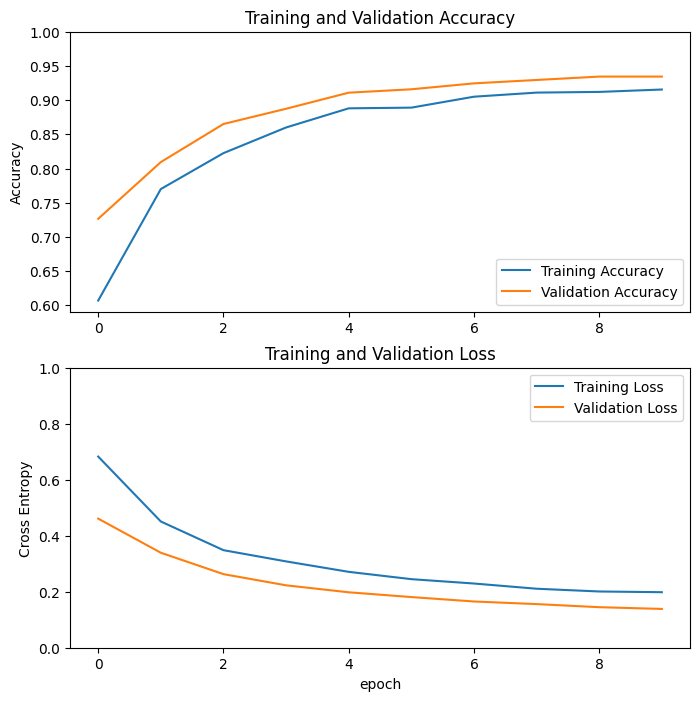

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Note:** If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.
To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

### Fine tuning



In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [ ]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 110

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

#compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

# continue traininig
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.8468 - loss: 0.4025 - val_accuracy: 0.9752 - val_loss: 0.0847
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.9088 - loss: 0.2402 - val_accuracy: 0.9876 - val_loss: 0.0608
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9204 - loss: 0.2047 - val_accuracy: 0.9827 - val_loss: 0.0542
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.9272 - loss: 0.1848 - val_accuracy: 0.9839 - val_loss: 0.0480
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.9474 - loss: 0.1388 - val_accuracy: 0.9814 - val_loss: 0.0474
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9413 - loss: 0.1228 - val_accuracy: 0.9839 - val_loss: 0.0421
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9600 - loss: 0.1091 - val_accuracy: 0.9864 - val_loss: 0.0402
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.9619 - loss: 0.1046 - val_accuracy: 0

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

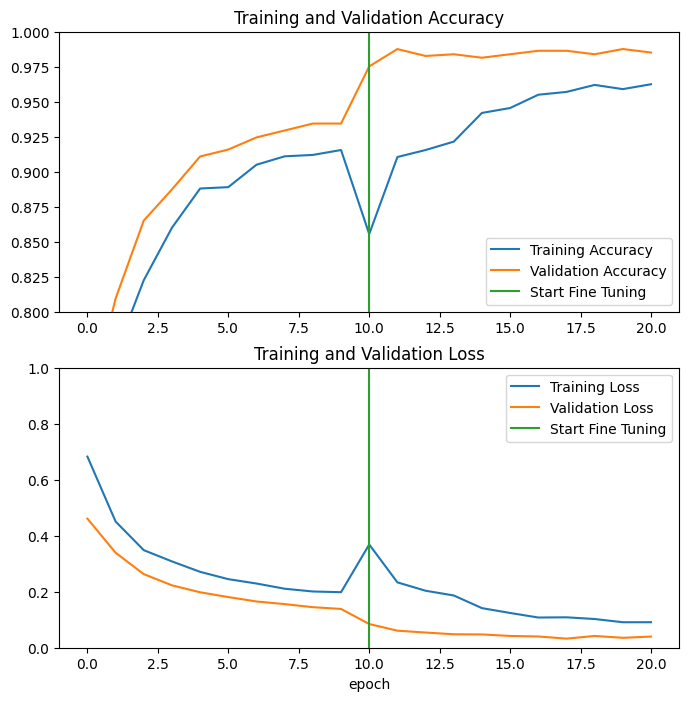

In [ ]:

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs,initial_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs,initial_epochs],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction
Finally you can verify the performance of the model on new data using test set.

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9598 - loss: 0.1067
Test accuracy : 0.9739583134651184
Predictions:
 [1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0]
Labels:
 [1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 1 0]


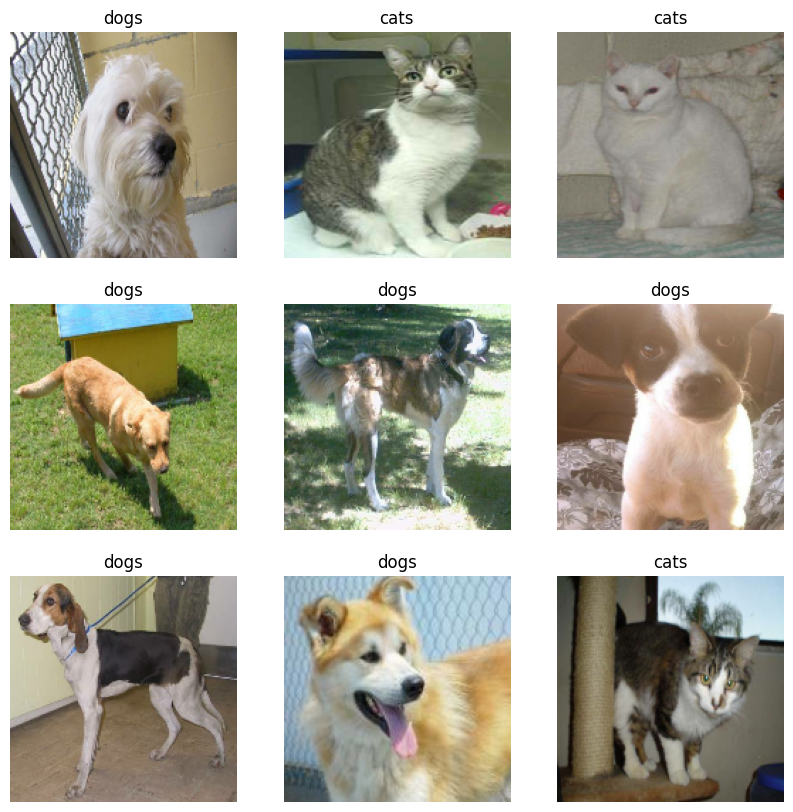

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

### Summary


The outputs suggest that MobileNet V2 provided a noticeable improvement in both training and validation accuracy over the basic CNN models in Part 1. Trained on the extensive ImageNet dataset, MobileNet V2 brought pre-learned features that helped it generalize well to the cats-and-dogs dataset, even with only 2000 images. Without fine-tuning, MobileNet V2 achieved higher validation accuracy compared to any of the VGG models, underscoring the benefits of transfer learning when dealing with limited data.

Fine-tuning further enhanced the model’s performance, as select layers in MobileNet V2 were unfrozen and retrained specifically for the cats-and-dogs task. This adjustment led to notable improvements in validation accuracy, bringing it close to training accuracy and reducing the risk of overfitting. Fine-tuning allowed the model to specialize its pre-trained features for this specific task, leveraging both general and specific knowledge for better accuracy and lower validation loss.

The gap between training and validation accuracy was also significantly reduced in MobileNet V2 compared to the basic CNNs, reflecting its improved generalization ability.